## Read the data files

In [1]:
import pandas as pd
fptrain = "../../../data/cleaned_sba_7a_loans_train.parquet"
fptest = "../../../data/cleaned_sba_7a_loans_test.parquet"
df_train = pd.read_parquet(fptrain)

In [2]:
preds = df_train.columns.tolist()
preds = [p for p in preds if p not in["LoanStatus", "SBAGuaranteedApproval"]]
df_X_train = df_train[preds]
df_Y_train = df_train["LoanStatus"]

## Develop the Base Logistic Regression Classifier with WOE features

In [3]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, random_state=0).fit(df_X_train, df_Y_train)

In [4]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve

In [5]:
df_test = pd.read_parquet(fptest)
df_X_test = df_test[preds]
df_Y_test = df_test["LoanStatus"]

## Evaluate and Inspect Proabability Estimates from the Base Classifier

In [6]:
uncalibrated_probab_train = clf.predict_proba(df_X_train)[:,1]

In [7]:
uncalibrated_probab_test = clf.predict_proba(df_X_test)[:,1]

In [8]:
prob_true_u, prob_pred_u = calibration_curve(df_Y_test, uncalibrated_probab_test, n_bins=10)

In [9]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

In [10]:
disp = CalibrationDisplay(prob_true_u, prob_pred_u, uncalibrated_probab_test)

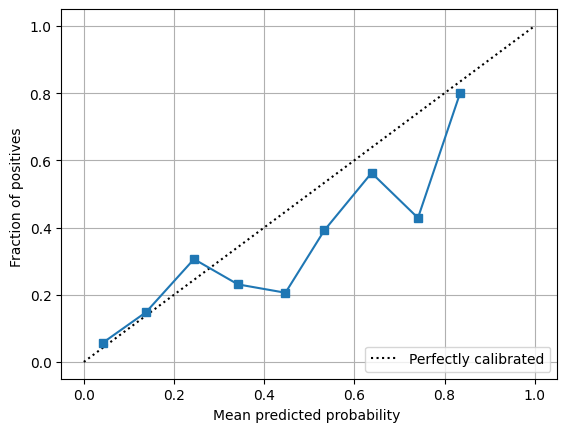

In [11]:
disp.plot()
disp.ax_.grid()

## Recalibrate Base Classifier with Isotonic Regression

In [12]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(clf, cv=3, method="isotonic")
calibrated_clf.fit(df_X_train, df_Y_train)

CalibratedClassifierCV(cv=3,
                       estimator=LogisticRegressionCV(cv=5, random_state=0),
                       method='isotonic')

In [13]:
calibrated_probab_test = calibrated_clf.predict_proba(df_X_test)[:,1]
calibrated_probab_train =  calibrated_clf.predict_proba(df_X_train)[:,1]

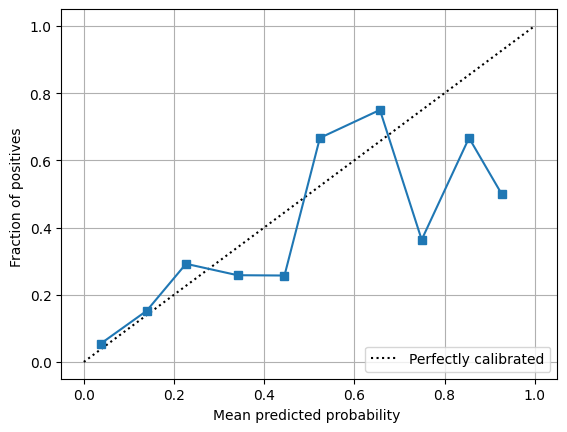

In [14]:
prob_true_c, prob_pred_c = calibration_curve(df_Y_test, calibrated_probab_test, n_bins=10)
disp = CalibrationDisplay(prob_true_c, prob_pred_c, calibrated_probab_test)
disp.plot()
disp.ax_.grid()

## Imbalance Translates to Predicted Probabilities
An evaluation of the histogram shows that most of the predictions are associated with very low probabilities of default. We have very few data points in the higher predicted probability range. This is consistent with the class imbalance. Even though it is ameliorated, we still will find very few loans with high predicted probability of charge off.

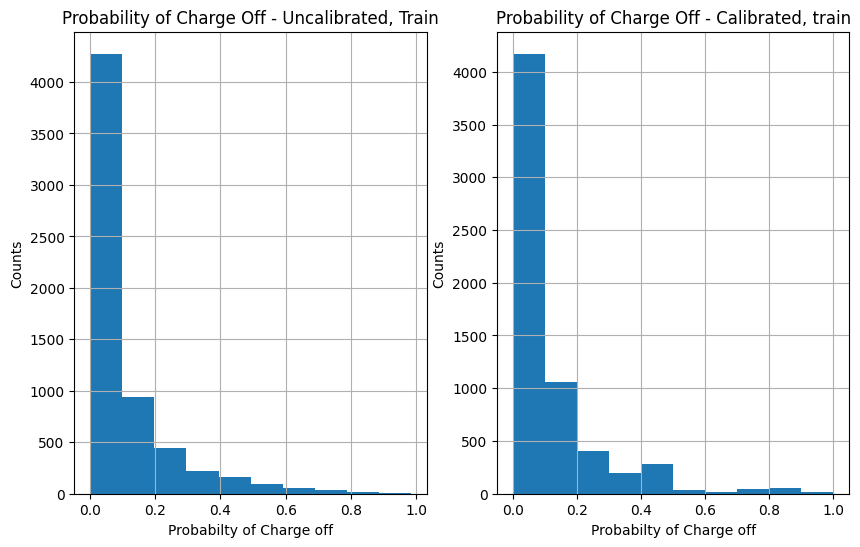

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
_ = plt.hist(uncalibrated_probab_train)
plt.title("Probability of Charge Off - Uncalibrated, Train")
plt.xlabel("Probabilty of Charge off")
plt.ylabel("Counts")
plt.grid()
plt.subplot(1,2,2)
_= plt.hist(calibrated_probab_train)
plt.title("Probability of Charge Off - Calibrated, train")
plt.xlabel("Probabilty of Charge off")
plt.ylabel("Counts")
plt.grid()

## Plot the ROC Curve
Note that this block computes the threshold probability based on maximizing the geometric mean

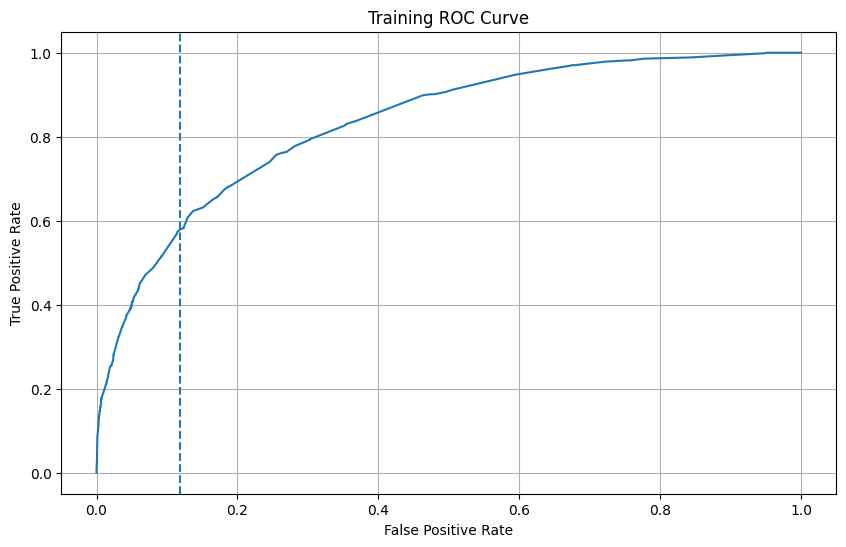

In [16]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
import numpy as np


# Find the optimal threshold

fpr_train, tpr_train, thresholds_train = roc_curve(df_Y_train, calibrated_probab_train, pos_label=clf.classes_[1])
gmean_train = np.sqrt(tpr_train * (1 - fpr_train))
index = np.argmax(gmean_train)
THRESHOLD_FOR_PREDICTING_CHG_OFF = thresholds_train[index]

plt.figure(figsize=(10,6))
plt.title("Training ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr_train, tpr_train)
plt.axvline(x=THRESHOLD_FOR_PREDICTING_CHG_OFF, linestyle="dashed")
plt.grid()


## Plot the Precision-Recall Curve
We use this curve to understand the performance of the classifier. We can use this curve to understand the true positive rates to expect with the sensitivity (recall) that we want. If true positive rates are low, we can anticipate higher false positives.

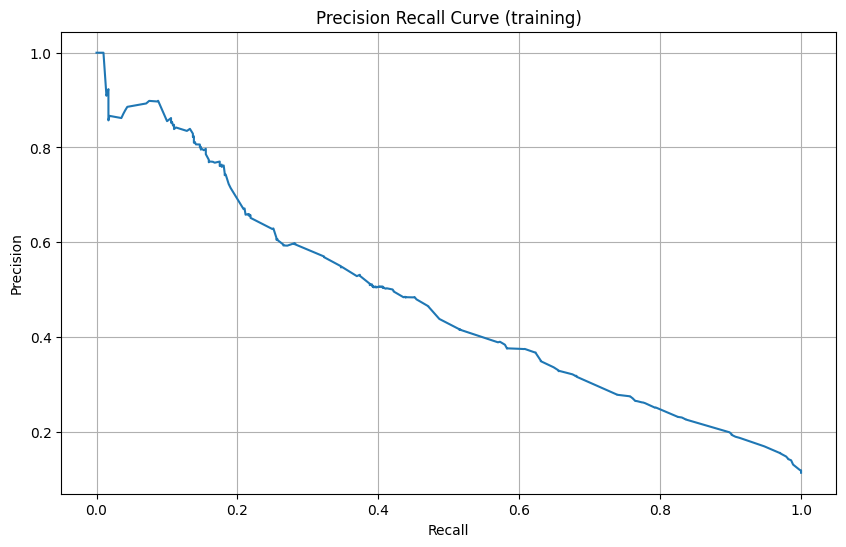

In [17]:
 precision, recall, thresholds  = precision_recall_curve(df_Y_train, calibrated_probab_train)
plt.figure(figsize=(10,6))
plt.title("Precision Recall Curve (training)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)
#plt.axvline(x=0.11873619537863306, linestyle="dashed")
plt.grid()


## Threshold Moving Calculation

In [18]:
from sklearn.metrics import recall_score, precision_score
pred_range_start = THRESHOLD_FOR_PREDICTING_CHG_OFF - (THRESHOLD_FOR_PREDICTING_CHG_OFF/2)
pred_range_end = THRESHOLD_FOR_PREDICTING_CHG_OFF + (THRESHOLD_FOR_PREDICTING_CHG_OFF/2)
pred_thresholds = np.linspace(pred_range_start, pred_range_end, num=10)
test_recall = []
test_precision = []
train_recall = []
train_precision = []
for thresh in pred_thresholds:
    pred_test_fn = lambda x : 1 if x >= thresh else 0 
    vfunc = np.vectorize(pred_test_fn)
    pred_test_labels = vfunc(calibrated_probab_test)
    pred_train_labels = vfunc(calibrated_probab_train)
    test_recall.append(recall_score(df_Y_test, pred_test_labels))
    test_precision.append(precision_score(df_Y_test, pred_test_labels))
    train_recall.append(recall_score(df_Y_train, pred_train_labels))
    train_precision.append(precision_score(df_Y_train, pred_train_labels))
    

In [19]:
pd.DataFrame({"threshold": pred_thresholds, "prec_test": test_precision, "recall_test": test_recall,\
             "prec_train": train_precision, "recall_train": train_recall})

,threshold,prec_test,recall_test,prec_train,recall_train
0,0.059153,0.181065,0.827027,0.198442,0.898449
1,0.072298,0.203216,0.751351,0.229630,0.830748
2,0.085443,0.220367,0.713514,0.250334,0.792666
3,0.098588,0.230906,0.702703,0.261553,0.774330
4,0.111734,0.231618,0.681081,0.269327,0.761636
5,0.124879,0.274752,0.600000,0.316721,0.681241
6,0.138024,0.276382,0.594595,0.320831,0.675599
7,0.151169,0.284946,0.572973,0.329087,0.655853
8,0.164314,0.291925,0.508108,0.365894,0.623413
9,0.177459,0.293750,0.508108,0.366805,0.623413


## KMDS Logging
We wish to indicate that this workflow depends on the feature engineering workflow. The workflow entity is embedded in the feature engineering knowledge base. To get the workflow entity, we load the feature engineering knowledge base, locate the workflow within the knowledge base and save it. When we create the new workflow to log observations for modeling work done in this notebook, we add it to the _depends_on_ list in the ontology associated with the new workflow. This is what it takes to connect workflows. Ideally, as this project gets bigger, knowledge bases should be stored in a separate repository or registry. This look up of workflows will be provided by that service and the work of the next cell will be abstracted away into a convinient lookup method.

In [20]:
from kmds.ontology.kmds_ontology import *
from kmds.tagging.tag_types import ExploratoryTags

from kmds.utils.load_utils import *
RP_DEP_KB = "../feature_engineering/sba_7a_loans_WOE_DR_dev.xml"

try:
    onto2 = get_ontology(RP_DEP_KB).load()
    workflow_instances = Workflow.instances()
except Exception as e:
    print("Error opening KB, check if KB exists and permissions are right")
if onto is None:
    print("Could not load Ontology, check the file and try again.")



### Start logging the observations from this modeling exercise

In [21]:
kaw = KnowledgeApplicationWorkflow("WOE_modeling_7a_charge_offs")

### Add the dependency to the feature engineering workflow obtained earlier

### verify that it is set as desired

In [22]:
kaw.depends_on = [workflow_instances[0]]

In [23]:
kaw.depends_on[0].name

'sba_7a_loans_WOE_DR_dev'

In [24]:
from kmds.tagging.tag_types import ModelSelectionTags, ModellingChoiceTags
ms_obs_list = []
ms_observation_count = 1

ms1 = ModelSelectionObservation(namespace=onto)
ms1.finding = "Logistic Regression using WOE encoding features was evaluated"
ms1.finding_sequence = ms_observation_count
ms1.model_selection_observation_type = ModelSelectionTags.MODEL_SELECTION_OBSERVATION.value
ms_obs_list.append(ms1)
ms_observation_count += 1

In [25]:
mc_obs_list = []
mc_observation_count = 1

mc1 = ModellingChoiceObservation(namespace=onto)
mc1.finding = "Model Evaluation is done using 5 fold cross validation and with L2 regularization"
mc1.finding_sequence = mc_observation_count
mc1.modelling_choice_observation_type = ModellingChoiceTags.MODELLING_CHOICE_OBSERVATION.value
mc_obs_list.append(mc1)
mc_observation_count += 1

mc2 = ModellingChoiceObservation(namespace=onto)
mc2.finding = "Isotonic Regression is used for model recalibration."
mc2.finding_sequence = mc_observation_count
mc2.modelling_choice_observation_type = ModellingChoiceTags.MODELLING_CHOICE_OBSERVATION.value
mc_obs_list.append(mc2)
mc_observation_count += 1

mc3 = ModellingChoiceObservation(namespace=onto)
mc3.finding = "Maximal Geometric Mean from ROC curve plot is used to prime the threshold moving experiment"
mc3.finding_sequence = mc_observation_count
mc3.modelling_choice_observation_type = ModellingChoiceTags.MODELLING_CHOICE_OBSERVATION.value
mc_obs_list.append(mc3)
mc_observation_count += 1

mc4 = ModellingChoiceObservation(namespace=onto)
mc4.finding = "An interval of 50 percent of the optimal threshold value on either direction is explored as part of threshold moving."
mc4.finding_sequence = mc_observation_count
mc4.modelling_choice_observation_type = ModellingChoiceTags.MODELLING_CHOICE_OBSERVATION.value
mc_obs_list.append(mc4)

kaw.has_modeling_choice_observations = mc_obs_list
kaw.has_model_selection_observations = ms_obs_list

KNOWLEDGE_BASE = "WOE_modeling_7a_charge_offs.xml"
onto.save(file=KNOWLEDGE_BASE, format="rdfxml")